In [23]:
# Goal: predict lnSalary in Hitters data set via boosting
# Packages/Options:
rm(list=ls())
library(ISLR)
library(gbm)
library(glmnet)
library(randomForest)

In [24]:
# Part a: Remove obs for salary info is unknown, and log xform salaries:
attach(Hitters)
table(Salary, useNA="always")
# 59 values of NA to remove: 
Hitters_clean <- Hitters[!is.na(Salary),]
nrow(Hitters); nrow(Hitters_clean)
detach(Hitters); attach(Hitters_clean)
# Log Xform:
Hitters_clean$lnSalary <- log(Salary)
fix(Hitters_clean)
# Drop Salary:
Hitters_clean <- subset(Hitters_clean, select = -c(Salary))
fix(Hitters_clean)
# Perfect.

Salary
    67.5       68       70       75       80     86.5     87.5       90 
       1        1        5        5        1        1        1        6 
    91.5       95     97.5      100      105      110      115      120 
       1        1        1        6        2        4        1        2 
     125      130      135      137      140      145      150      155 
       1        1        2        1        3        2        2        3 
     160      165      172      175      180      185      190      191 
       2        2        1        4        1        1        2        1 
     195      200    202.5      210      215      225      230      235 
       1        4        1        2        3        2        1        1 
     240      245    247.5      250      260      265      275    277.5 
       2        1        1        6        1        1        3        2 
 286.667    297.5      300      305      320      325  326.667      340 
       1        1        5        1        1

[1] 322

[1] 263

In [25]:
# Part b: Create a train set of first 200 obs, and test set of rest:
# Helper variable for number of records:
num_row <- nrow(Hitters_clean) 
train   <- Hitters_clean[1:200 ,]
test    <- Hitters_clean[201:num_row,]
nrow(train); nrow(test); print(num_row)

[1] 200

[1] 63

[1] 263


In [26]:
# Helper function for MSE:
mse_fun <- function(actual, predicted)
{
    mse_val <- mean((actual-predicted)^2)
    return(mse_val)
}

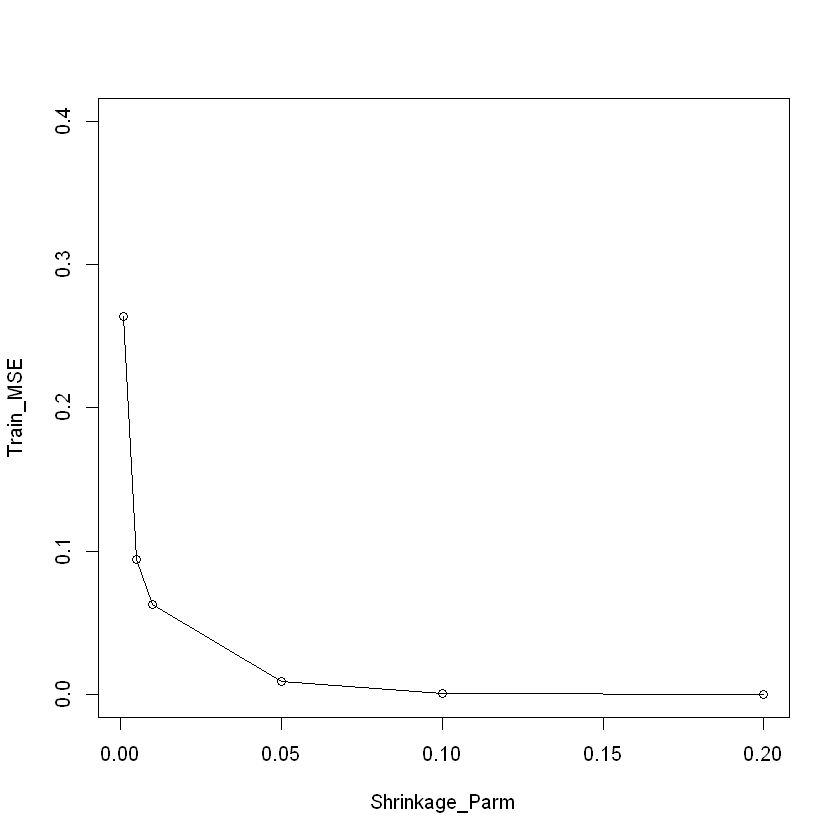

          [,1]
[1,] 0.3061374
[2,] 0.2840542
[3,] 0.2730888
[4,] 0.2824752
[5,] 0.2706161
[6,] 0.3013025


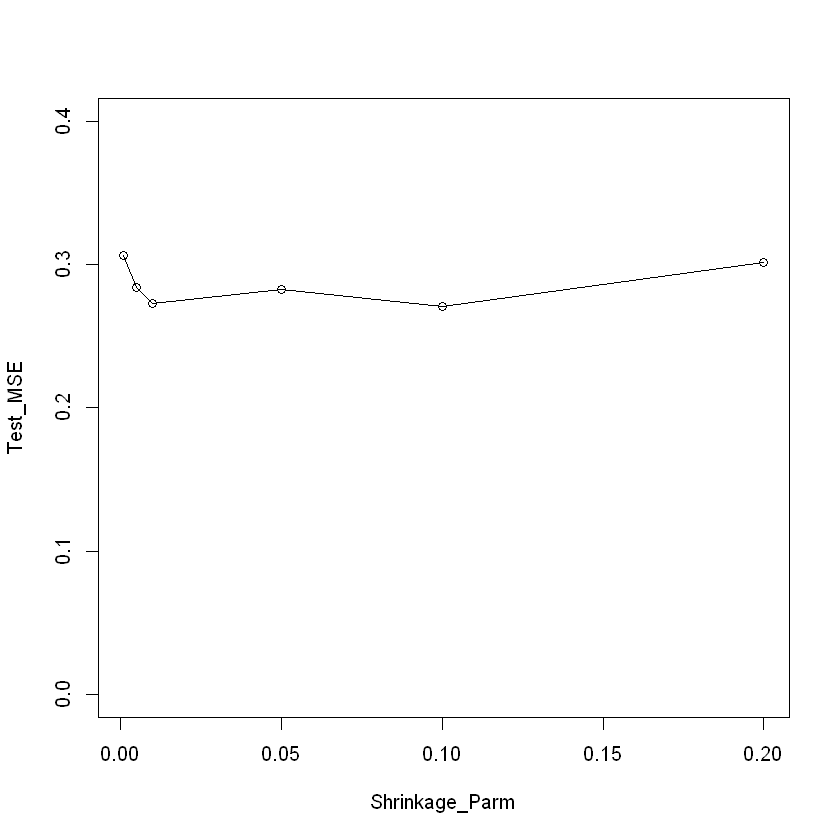

In [27]:
# Part c: Perform boosting on train set with 1,000 trees for a range of values
# for the shrinkage parameter. Produce plot with x=shrinkage vals and y=train set MSE.
# Part d: Produce analogous plot except with y=test set MSE.
lambda              <- c(1,5,10,50,100,200)*(10^-3)
num_trees           <- 1000
int_depth           <- 4
train_mse_storage   <- matrix(0, nrow=length(lambda), ncol=1)
test_mse_storage    <- matrix(0, nrow=length(lambda), ncol=1)
# Loop thru vals of lambda:
set.seed(1)
for (i in 1:length(lambda))
{
    boost.hitters        <- gbm(lnSalary~., data=train, distribution="gaussian", 
                                n.trees=num_trees, interaction.depth=int_depth, 
                                shrinkage=lambda[i])
    boost.pred.train     <- predict(boost.hitters, newdata=train, n.trees=num_trees)
    boost.pred.test      <- predict(boost.hitters, newdata=test, n.trees=num_trees)
    train_mse_storage[i] <- mse_fun(actual=train$lnSalary, predicted=boost.pred.train)
    test_mse_storage[i]  <- mse_fun(actual=test$lnSalary, predicted=boost.pred.test)
}

# Produce plot with x=shrinkage values and y=TRAIN set MSE:
plot(lambda, train_mse_storage, xlab="Shrinkage_Parm", ylab="Train_MSE",
         ylim=c(0,0.4))
lines(lambda, train_mse_storage)
# Clearly for the neighborhood of values of the shrinkage parms I chose,
# (conditional on num_trees=1000), larger values of the shrinkage parm
# yield smaller train set MSE.

# Produce plot with x=shrinkage values and y=TEST set MSE:
plot(lambda, test_mse_storage, xlab="Shrinkage_Parm", ylab="Test_MSE",
        ylim=c(0,0.4))
lines(lambda, test_mse_storage)
print(test_mse_storage)
# Clearly given my chosen values of lambda here, 100*10^(-3)=0.1 appears optimal
# for minimizing test set MSE.

In [28]:
# Part e: Compare the test set MSE from boosting to that from two of the approaches
# seen in Chapters 3 and 6.
# First, we apply Multiple Linear Regression from Chapter 3:
mult_reg      <- lm(lnSalary~., data=train)
mult_reg_pred <- predict(mult_reg, newdata=test)
mult_reg_mse  <- mse_fun(actual=test$lnSalary, predicted=mult_reg_pred)
print(round(mult_reg_mse,2))
# Clearly this provides a much worse result than boosting.

[1] 0.49


[1] 0.003804293
[1] 0.470371


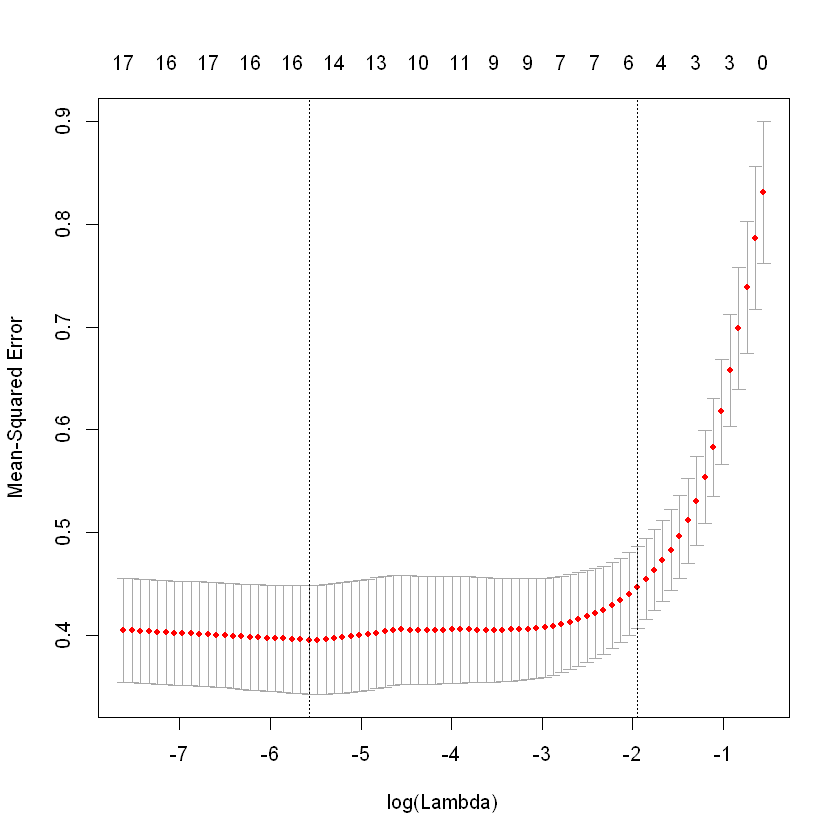

In [34]:
# Second, we apply the LASSO:
set.seed(1)
x_var          <- model.matrix(lnSalary~., train)[,-1]
y_var          <- train$lnSalary
grid           <- 10^(seq(10, -2, length=100))
cv.out         <- cv.glmnet(x_var, y_var, alpha=1)
plot(cv.out)
best_lam       <- cv.out$lambda.min
print(best_lam)
# Predict:
lasso_reg      <- glmnet(x_var, y_var, alpha=1, lambda=grid)
lasso.pred     <- predict(lasso_reg, s=best_lam, newx=model.matrix(lnSalary~., test)[,-1])
lasso.mse       <- mse_fun(actual=test$lnSalary, predicted=lasso.pred)
print(lasso.mse)
# LASSO Test MSE is slightly smaller than OLS, but still much larger than boosting.

,var,rel.inf
,<fct>,<dbl>
CRuns,CRuns,17.4682321
CAtBat,CAtBat,15.3053721
CHits,CHits,10.4985753
CHmRun,CHmRun,9.2389669
PutOuts,PutOuts,6.3383004
Walks,Walks,5.6272337
AtBat,AtBat,5.2478115
CRBI,CRBI,5.0086733
Years,Years,4.7635344


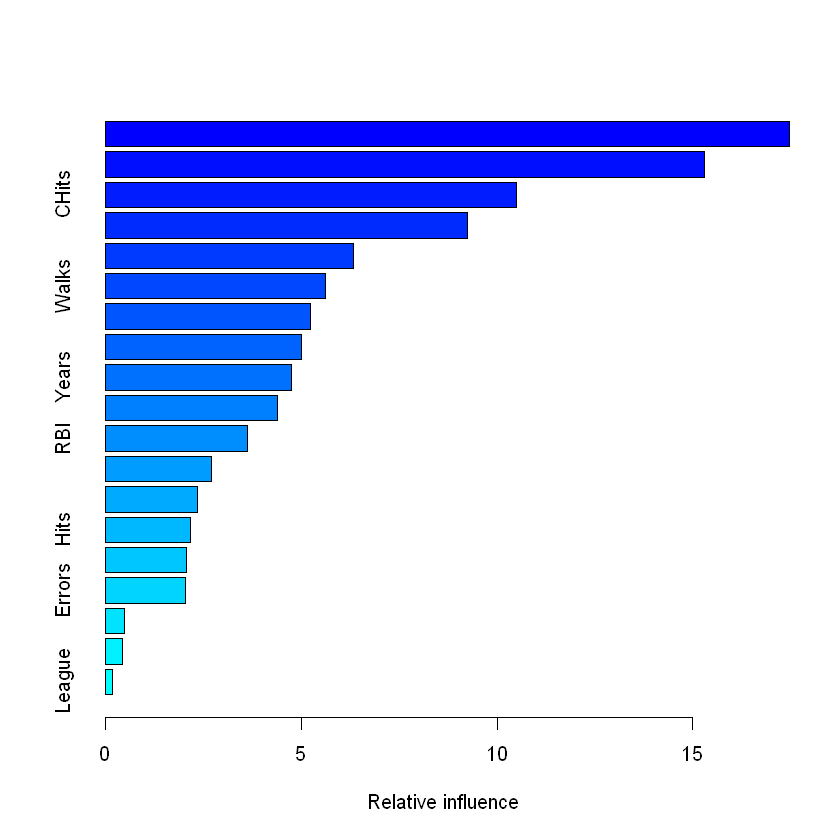

In [35]:
# Part f: 
summary(boost.hitters)
# Clearly CRuns and CAtBat appear to be the most important
# variables in the boosted model.

In [38]:
# Part g: Now we apply bagging via randomForest:
bag.Hitters <- randomForest(lnSalary~., data=train, mtry=(ncol(train)-1), 
                    importance=TRUE)
bag.pred    <- predict(bag.Hitters, newdata=test)
bag.mse     <- mse_fun(actual=test$lnSalary, predicted=bag.pred)
print(bag.mse)
# Interestingly enough, this test MSE is about 20% smaller than boosting
# with the specified parms!

[1] 0.2276953
